- Accent-recognizing model, same as in main2.ipynb
- Including Yamnet model.
- Including hyperparam tuning.
- Plugged the updated dataset from Alex and Peter.

In [ ]:
%pip install -U -q tensorflow tensorflow_datasets
#apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
%pip install -U -q keras-tuner

In [59]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import pathlib
import os
from os.path import isfile, join, splitext
import librosa
import soundfile as sf
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import tensorflow_hub as tfhub
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
import keras_tuner as kt

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio

SAMPLING_RATE = 16000
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_SEED = 42
MODEL_NAME = "MODEL6"

# Set the seed value for experiment reproducibility.
tf.random.set_seed(SHUFFLE_SEED)
np.random.seed(SHUFFLE_SEED)

### Prepare dataset using Yamnet model as feature-extractor

Yamnet requires a slightly different way of preprocessing the dataset.

In [24]:
yamnet_model = tf.saved_model.load('./yamnet_1')

In [56]:
dataframe = pd.read_csv(os.getcwd() + "/data/audio10.csv", on_bad_lines = 'skip' , delimiter= ';')
# dataframe = dataframe[(dataframe['native_langs'] == 'english') | (dataframe['native_langs'] == 'spanish')]

class_names = dataframe['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))
print(f"There are {len(class_names)} classes.")

# Rewrite file_name to contain file paths
dataframe['file_name'] = dataframe.apply(
    lambda row: os.path.join(os.getcwd(), 'data/downsampled', row['file_name'] + '.wav'), 
    axis=1
)

There are 53 classes.


In [25]:
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    # labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    # Convert the labels into numbers -- no longer necessary since we're targetting the class_labels column
    # dataframe['native_langs'] = dataframe.apply(
    #     lambda row: class_dict[row['native_langs']],
    #     axis=1
    # )

    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [57]:
X = dataframe.iloc[:, :-1]
y = dataframe['class_labels']
sss = StratifiedShuffleSplit(test_size=0.2, random_state=SHUFFLE_SEED)
for train_index, test_val_index in sss.split(X, y):
    X_train, X_test_val = X.iloc[train_index], X.iloc[test_val_index]
    y_train, y_test_val = y.iloc[train_index], y.iloc[test_val_index]

# additional split of test_val set to test and validation set
sss_val = StratifiedShuffleSplit(test_size=0.5, random_state=SHUFFLE_SEED)
for val_index, test_index in sss_val.split(X_test_val, y_test_val):
    X_val, X_test = X_test_val.iloc[val_index], X_test_val.iloc[test_index]
    y_val, y_test = y_test_val.iloc[val_index], y_test_val.iloc[test_index]

print(f'''
Splitting success!
X: {len(X)}, y: {len(y)}
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
X_test: {len(X_test)}, y_test: {len(y_test)}
''')

train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
validation_ds = dataframe_to_dataset(X_val['file_name'], y_val)
test_ds = dataframe_to_dataset(X_test['file_name'], y_test)

print('Conversion to dataset success!')


Splitting success!
X: 2546, y: 2546
X_train: 2036, y_train: 2036
X_val: 255, y_val: 255
X_test: 255, y_test: 255

Conversion to dataset success!


### Build the model for hyperparameter tuning

In [28]:
def build_and_compile_model(hp):
    inputs = keras.layers.Input(shape=(1024), name="embedding")

    # Tune the number of units in the first Dense layer. Choose an optimal value between 32-512
    hp_units = hp.Int('dense_layer_1', min_value=32, max_value=512, step=32)
    x = keras.layers.Dense(units=hp_units, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    # Tune the learning rate for the optimizer. Choose an optimal value from 0.001, 0.0001, or 1.9644e-5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1.9644e-5])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )
    # model.summary()

    return model

In [30]:
# Instantiate the hyperparameter tuner. 
# Set overwrite=False to continue the search from last session, overwrite=True to start new search everytime.

tuner = kt.Hyperband(build_and_compile_model,
                    objective='val_accuracy',
                    max_epochs=20,
                    factor=3,
                    hyperband_iterations=10,
                    directory='uu_accent_detection_dir',
                    project_name='uu_accent_detection',
                    overwrite=False)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, 
            epochs=20, 
            validation_data=validation_ds, 
            callbacks=[stop_early],
            verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is {best_hps.get('dense_layer_1')}. 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 39 Complete [00h 01m 18s]
val_accuracy: 0.21359027922153473

Best val_accuracy So Far: 0.21359027922153473
Total elapsed time: 02h 52m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layers is 352. 
The optimal learning rate for the optimizer is 0.001.



#### Class weight calculation

Since the dataset is quite unbalanced, we wil use class_weight argument during training.

Getting the class weights is a little tricky because even though we know the number of audio files for each class, it does not represent the number of samples for that class since Yamnet transforms each audio file into multiple audio samples of 0.96 seconds each. So every audio file will be split into a number of samples that is proportional to its length.

Therefore, to get those weights, we have to calculate the number of samples for each class after preprocessing through Yamnet.

In [60]:
class_counts = tf.zeros(shape=(len(class_names),), dtype=tf.int32)

for x, y in iter(train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 1.6871604973848393, 1: inf, 2: inf, 3: 214.45787545787545, 4: inf, 5: inf, 6: 81.48503827418233, 7: 10.525303370786517, 8: inf, 9: inf, 10: inf, 11: inf, 12: inf, 13: inf, 14: inf, 15: inf, 16: inf, 17: inf, 18: inf, 19: inf, 20: inf, 21: 110.98957345971564, 22: 205.06830122591944, 23: 127.4145810663765, 24: inf, 25: inf, 26: 69.12278630460449, 27: inf, 28: inf, 29: inf, 30: inf, 31: inf, 32: inf, 33: inf, 34: inf, 35: inf, 36: inf, 37: inf, 38: 178.22526636225265, 39: inf, 40: 52.041777777777774, 41: inf, 42: inf, 43: 4.757404623572909, 44: 144.0270602706027, 45: inf, 46: inf, 47: inf, 48: inf, 49: 58.226752859273994, 50: inf, 51: inf, 52: inf}


/var/folders/3p/fc9cp69s1lsfgnzqtqtddvz00000gn/T/ipykernel_36211/1312827400.py:9: RuntimeWarning: divide by zero encountered in int_scalars
  i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()


### Train the model

We use Keras callbacks in order to:

- Stop whenever the validation AUC stops improving.
- Save the best model.
- Call TensorBoard in order to later view the training and validation logs.

In [62]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
hypermodel = tuner.hypermodel.build(best_hps)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_auc", patience=10, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(MODEL_NAME + ".h5", monitor="val_auc", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(os.path.join(os.curdir, "logs", hypermodel.name))

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
hp = kt.HyperParameters()

history = hypermodel.fit(train_ds, 
                        validation_data=validation_ds,
                        epochs=EPOCHS,
                        class_weight=class_weight,
                        batch_size=hp.Choice(name='batch_size', values=[16, 32]),
                        callbacks=callbacks,
                        verbose=2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# Save model
# hypermodel.save('tuned_model.h5')
# Load model
# model = keras.models.load_model('tuned_model.h5')

Epoch 1/50
1830/1830 - 30s - loss: 41.9586 - accuracy: 0.0287 - auc: 0.8691 - val_loss: 1.1381 - val_accuracy: 0.0038 - val_auc: 0.9027 - 30s/epoch - 16ms/step
Epoch 2/50
1830/1830 - 23s - loss: 205.4545 - accuracy: 0.0200 - auc: 0.8215 - val_loss: 1.1967 - val_accuracy: 0.0175 - val_auc: 0.8811 - 23s/epoch - 13ms/step
Epoch 3/50
1830/1830 - 23s - loss: 503.8290 - accuracy: 0.0261 - auc: 0.7700 - val_loss: 1.0802 - val_accuracy: 0.0208 - val_auc: 0.8950 - 23s/epoch - 13ms/step
Epoch 4/50
1830/1830 - 23s - loss: 14217.5459 - accuracy: 0.0328 - auc: 0.6575 - val_loss: 100.7982 - val_accuracy: 0.0044 - val_auc: 0.4957 - 23s/epoch - 12ms/step
Epoch 5/50
1830/1830 - 20s - loss: 80202.3125 - accuracy: 0.0360 - auc: 0.5362 - val_loss: 5187.1733 - val_accuracy: 0.0044 - val_auc: 0.4957 - 20s/epoch - 11ms/step
Epoch 6/50
1830/1830 - 23s - loss: 589200.5625 - accuracy: 0.0342 - auc: 0.5329 - val_loss: 58471.6445 - val_accuracy: 0.0044 - val_auc: 0.4957 - 23s/epoch - 12ms/step
Epoch 7/50
1830/183

#### Evaluation

In [63]:
train_loss, train_acc, train_auc = hypermodel.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = hypermodel.evaluate(validation_ds)
test_loss, test_acc, test_auc = hypermodel.evaluate(test_ds)

231/231 [==============================] - 68s 281ms/step - loss: 1.0524 - accuracy: 0.0044 - auc: 0.9033


Let's try to compare our model's performance to Yamnet's using one of Yamnet metrics (d-prime) Yamnet achieved a d-prime value of 2.318. Let's check our model's performance.

In [64]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 1.834, validation d-prime: 1.835


#### Results

Plotting the accuracy and AUC results.

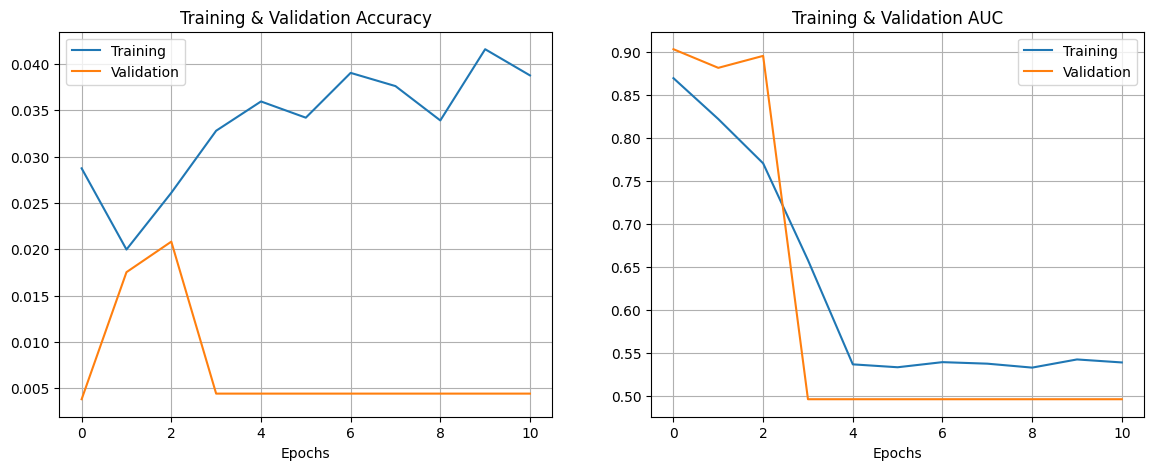

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(len(history.history["auc"])), history.history["auc"], label="Training")
axs[1].plot(range(len(history.history["val_auc"])), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

#### Confusion Matrix

Let's now plot the confusion matrix for the validation dataset.

The confusion matrix lets us see, for every class, not only how many samples were correctly classified, but also which other classes were the samples confused with.

It allows us to calculate the precision and recall for every class.

In [ ]:
# Create x and y tensors
x_valid = None
y_valid = None

for x, y in iter(validation_ds):
    if x_valid is None:
        x_valid = x.numpy()
        y_valid = y.numpy()
    else:
        x_valid = np.concatenate((x_valid, x.numpy()), axis=0)
        y_valid = np.concatenate((y_valid, y.numpy()), axis=0)

# Generate predictions
y_pred = hypermodel.predict(x_valid)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1)
)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

#### Precision & Recall

For every class:

- Recall is the ratio of correctly classified samples i.e. it shows how many samples of this specific class, the model is able to detect. It is the ratio of diagonal elements to the sum of all elements in the row.
- Precision shows the accuracy of the classifier. It is the ratio of correctly predicted samples among the ones classified as belonging to this class. It is the ratio of diagonal elements to the sum of all elements in the column.

In [ ]:
for i, label in enumerate(class_names):
    precision = confusion_mtx[i, i] / np.sum(confusion_mtx[:, i])
    recall = confusion_mtx[i, i] / np.sum(confusion_mtx[i, :])
    print(
        "{0:15} Precision:{1:.2f}%; Recall:{2:.2f}%".format(
            label, precision * 100, recall * 100
        )
    )